In [123]:
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io import loadmat

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision.transforms import Normalize
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch.nn as nn
import torch.nn.functional as F

In [124]:
input_layer_size = 400
hidden_layer1_size = 100
hidden_layer2_size = 50
num_labels = 10

In [125]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


## Loading data

In [126]:
data = loadmat("ex4data1.mat")
X = data['X']
y = np.array([0 if i==10 else i for i in data['y'].flatten()])
print(X.shape, y.shape)

(5000, 400) (5000,)


In [127]:
#randomly select 100 data points to display
rand_indices = random.sample(range(X.shape[0]), 100)
sel = X[rand_indices,:]

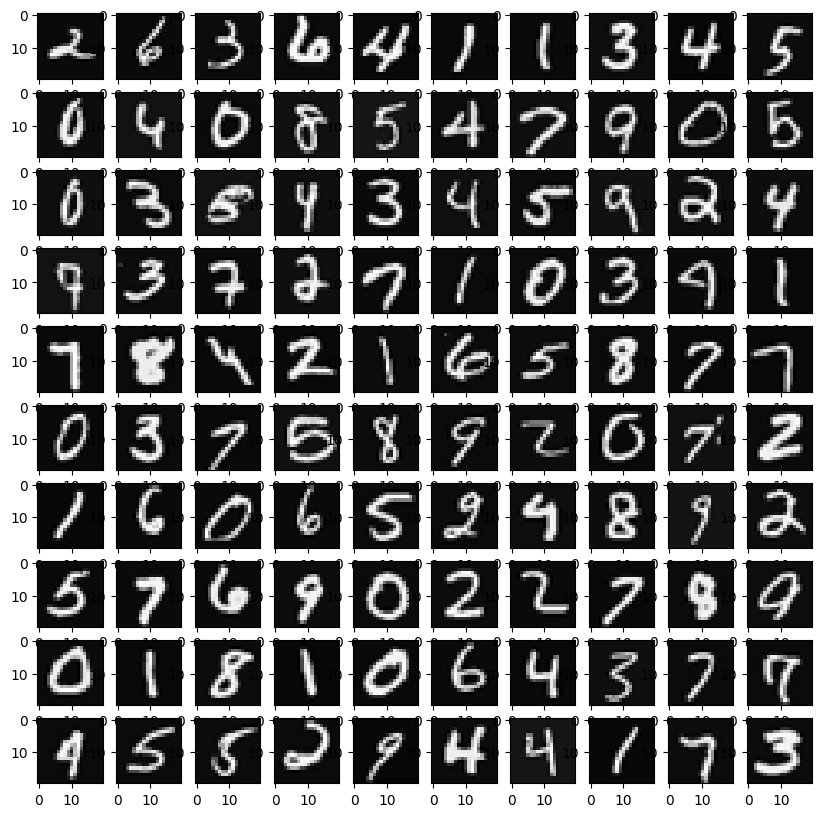

In [128]:
#Display the data as images
fig0, ax = plt.subplots(10,10,figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i][j].imshow(sel[10*i+j].reshape(20,20, order='F'), cmap='gray')#order 'F' orders by column, like fortran

## Split into train and validation set

In [129]:
Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.2, random_state=123)

In [130]:
#Get the set of images, and create the train and validation data sets
training_set = TensorDataset(F.normalize(torch.Tensor(Xtrn)), torch.Tensor(ytrn).to(torch.int64))
validation_set = TensorDataset(F.normalize(torch.Tensor(Xval)), torch.Tensor(yval).to(torch.int64))

In [131]:
#Report split sizes
print('Training set has {} instances'.format(len(training_set)));
print('Validation set has {} instances'.format(len(validation_set)));

Training set has 4000 instances
Validation set has 1000 instances


In [132]:
#Prepare batches that update at every epoch for training. Use multiprocessing
training_loader = DataLoader(training_set, batch_size=4, shuffle=True, num_workers=4);
validation_loader = DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=4);

## The model

In [133]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier,self).__init__()
        self.linear1 = nn.Linear(input_layer_size,hidden_layer1_size)
        self.linear2 = nn.Linear(hidden_layer1_size,hidden_layer2_size)
        self.final = nn.Linear(hidden_layer2_size, num_labels)
        self.afun1 = nn.ReLU()
        #self.afun2 = nn.Sigmoid()
        
    def forward(self, x):
        x = self.afun1(self.linear1(x))
        x = self.afun1(self.linear2(x))
        x = self.final(x)
        return x

In [134]:
model = DigitClassifier().to(device)

## Loss function

In [135]:
## use the log loss as cost function
loss_fn = nn.CrossEntropyLoss()

In [136]:
##Test the loss function##
#Pass data in batches of 4
#Returns 10 lists of 4 random numbers between 0 and 1 as a 4x10 tensor, to test confidence on each of the 10 classes
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the possible 10
dummy_labels = torch.tensor([1, 5, 0, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[2.8099e-01, 1.6418e-01, 8.7526e-01, 8.8528e-01, 2.4426e-01, 3.9117e-02,
         2.4262e-01, 7.8636e-04, 9.3615e-01, 2.3646e-01],
        [5.5984e-01, 2.0741e-01, 5.4867e-01, 8.1558e-01, 4.4800e-01, 5.9063e-01,
         3.3228e-01, 6.7173e-01, 7.1612e-01, 8.2383e-01],
        [2.7686e-01, 2.2008e-02, 6.4927e-01, 1.0048e-02, 1.1220e-01, 1.0274e-01,
         4.0443e-01, 1.8773e-01, 8.2347e-01, 3.0840e-01],
        [6.2707e-01, 7.5605e-01, 5.7961e-02, 8.1976e-01, 6.0949e-01, 4.0966e-01,
         2.7994e-02, 9.0122e-01, 5.9159e-02, 7.8488e-01]])
tensor([1, 5, 0, 7])
Total loss for this batch: 2.299882173538208


## Optimizer

In [137]:
#Stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training loop
- Get a batch of data from the Data Loader
- Zero the optimizer's gradients
- Gets predictions from the model for an imput batch
- Computes the loss function for the prediction
- Adjusts the model's weights with gradient descent
- Reports the loss for every 1000 batches
- Reports the average per-batch loss for the last 1000 batches for comparison to a validation run

In [138]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    #Use an enumeration istead of an iterator to track the batch index and do reporting
    for i, data in enumerate(training_loader):
        #training instances are input + label pairs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #zero the gradients
        optimizer.zero_grad()
        
        #make predictions fo this batch
        outputs = model(inputs)
        
        #compute loss and its gradient
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        #adjust the weights
        optimizer.step()
        
        #gather data and report
        running_loss += loss.item()
        if i % 200 == 199:
            last_loss = running_loss / 200 #loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
            
    return last_loss

## Main loop
Before training an epoch there are a couple of things to do:
- Validate by checking the relative loss on a set of validation data and report it
- Save a copy of the model

We use TensorBoard to do the reporting.

In [139]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [140]:
EPOCHS = 30
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch_number + 1))
    
    #Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    #To do reporting gradients do not need to be on
    model.train(False)
    
    #Pull batches fron validation data to validate
    running_vloss = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i+1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    ##Log the runnig loss averaged per batch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                      {'Training': avg_loss, 'Validation': avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        
    epoch_number += 1

EPOCH 1
 batch 200 loss: 2.3040479052066805
 batch 400 loss: 2.3000980126857757
 batch 600 loss: 2.300787932872772
 batch 800 loss: 2.2986399650573732
 batch 1000 loss: 2.2978483748435976
LOSS train 2.2978483748435976 valid 2.295698881149292
EPOCH 2
 batch 200 loss: 2.292331371307373
 batch 400 loss: 2.293735454082489
 batch 600 loss: 2.289141232967377
 batch 800 loss: 2.2866019296646116
 batch 1000 loss: 2.28209730386734
LOSS train 2.28209730386734 valid 2.280635118484497
EPOCH 3
 batch 200 loss: 2.278333580493927
 batch 400 loss: 2.2682612562179565
 batch 600 loss: 2.2643315494060516
 batch 800 loss: 2.253582465648651
 batch 1000 loss: 2.2451343393325804
LOSS train 2.2451343393325804 valid 2.2382264137268066
EPOCH 4
 batch 200 loss: 2.2309673261642455
 batch 400 loss: 2.2080360680818556
 batch 600 loss: 2.182388367652893
 batch 800 loss: 2.145541328787804
 batch 1000 loss: 2.0943438071012497
LOSS train 2.0943438071012497 valid 2.084763765335083
EPOCH 5
 batch 200 loss: 2.041579218506

## Predict

In [142]:
#To load the saved version of the model
saved_model = DigitClassifier()
saved_model.load_state_dict(torch.load('./model_20220917_105843_9'))

<All keys matched successfully>

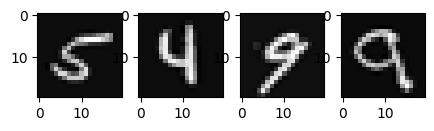

In [143]:
imgs, label = next(iter(validation_loader))
fig1, ax = plt.subplots(1,4,figsize=(5, 5))
for i in range(len(imgs)):
    #print(type(i.reshape(20,20)))
    ax[i].imshow(torch.transpose(imgs[i].reshape(20,20), 0, 1), cmap="gray")

In [148]:
out, idx = torch.max(saved_model(imgs), dim=1)
print(idx)
print(label)

tensor([5, 4, 9, 9])
tensor([5, 4, 9, 9])
